In [4]:
#!/usr/bin/env python
# coding: utf-8
import itertools
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

#显示中文
# 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 用来正常显示符号
plt.rcParams['axes.unicode_minus'] = False
#忽略警告
import warnings
warnings.filterwarnings("ignore")
#如果没有这个目录，则创建这个目录
if not os.path.isdir('result'):
    os.mkdir('result')

Using TensorFlow backend.


In [5]:
#arima-lstm=arima-->lstm--->predict

df = pd.read_csv("600639.csv")   
#读取数据
df.head()#查看数据前5行

,Unnamed: 0,date,open,close,high,low,volume,code
0,0,2021-01-04,11.60,11.60,11.70,11.53,49742.0,600639
1,1,2021-01-05,11.61,11.77,11.83,11.55,34874.0,600639
2,2,2021-01-06,11.69,11.67,11.85,11.60,19553.0,600639
3,3,2021-01-07,11.71,11.47,11.71,11.41,23466.0,600639
4,4,2021-01-08,11.45,11.58,11.62,11.36,21319.0,600639


In [6]:
#获取values列名数据
data=df['close']
date=df['date'] #获取date列日期数据

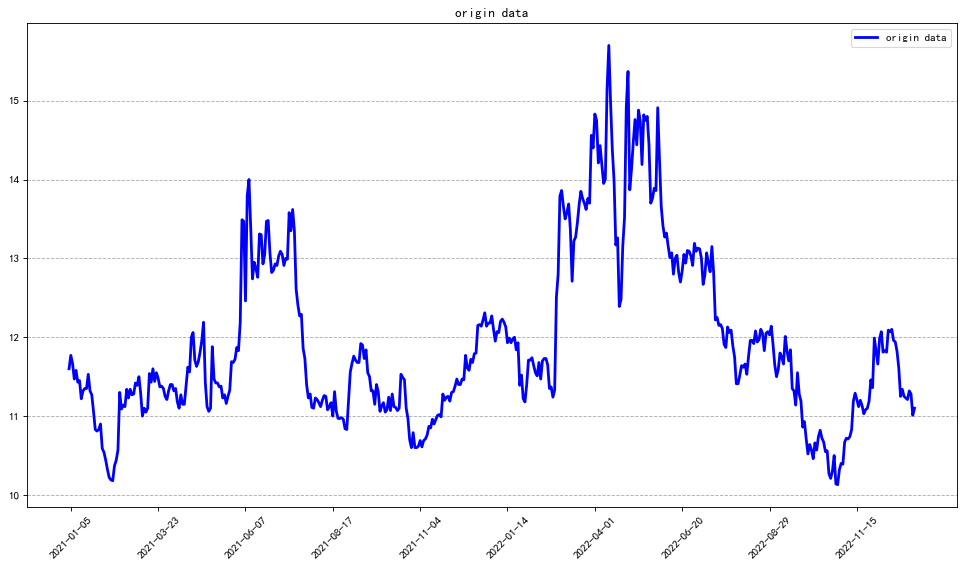

In [7]:
#显示原数据
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(date, data, label="origin data", color='b',lw=2.5)  #若不需要日期或者数据没有日期可改成plt.plot(data, label=" ", color='b',lw=2.5)
plt.title("origin data")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(data),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/origin_data.png')#图片保存路径
plt.show()

In [8]:
#定义稳定性检验函数
def adf_val(ts, ts_title):
    '''
    ts: 时间序列数据，Series类型
    ts_title: 时间序列图的标题名称，字符串
    '''
    # 稳定性（ADF）检验
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts)

    name = ['adf', 'pvalue', 'usedlag','nobs', 'critical_values', 'icbest']
    values = [adf, pvalue, usedlag, nobs,critical_values, icbest]
    print(list(zip(name, values)))

    return adf, pvalue, critical_values,
    # 返回adf值、adf的p值、三种状态的检验值

In [9]:
#白噪声检验也称为纯随机性检验，当数据是纯随机数据时，再对数据进行分析就没有任何意义了，所以拿到数据后最好对数据进行一个纯随机性检验。
def acorr_val(ts):
    '''
    # 白噪声（随机性）检验
    ts: 时间序列数据，Series类型
    返回白噪声检验的P值
    '''
    lbvalue, pvalue = acorr_ljungbox(ts, lags=1)  # 白噪声检验结果
    return lbvalue, pvalue



def tsplot(y, lags=None, figsize=(15, 8)):
    fig = figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)
    ts_ax.set_title('origin  data')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    #自相关（Autocorrelation）： 对一个时间序列，现在值与其过去值的相关性。如果相关性为正，则说明现有趋势将继续保持。
    plot_acf(y, lags=lags, ax=acf_ax)
    #可以度量现在值与过去值更纯正的相关性
    plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()

    fig.tight_layout()
    fig.savefig('result/ACF_PACF.png')#图片保存路径
    fig.show()

    return ts_ax, acf_ax, pacf_ax

In [10]:
#获取values列名的数据，并转为float32类型数据
ts_data = data.astype('float32')

In [11]:
#平稳性检验
adf1, pvalue1, critical_values1 = adf_val(ts_data, 'raw time series') #对原数据进行平稳性判断
print('adf',adf1)
print('pvalue1',pvalue1)
print('critical_values',critical_values1)
#结果显示，adf结果为-2.2394..， 不小于critical_values的三个level的统计值。pvalue也不接近于0 的，所以是不平稳的，所以需要做一阶差分
#若p值远小于0.01，认为该时间序列是平稳的

#白噪声检验
aco=acorr_val(ts_data)
print('aco',aco)


[('adf', -2.3951683740102387), ('pvalue', 0.14310474579198262), ('usedlag', 18), ('nobs', 466), ('critical_values', {'1%': -3.4444609168389615, '5%': -2.8677622536920317, '10%': -2.5700842229549266}), ('icbest', 126.20558339687136)]
adf -2.3951683740102387
pvalue1 0.14310474579198262
critical_values {'1%': -3.4444609168389615, '5%': -2.8677622536920317, '10%': -2.5700842229549266}
aco (array([455.61347146]), array([4.32997592e-101]))


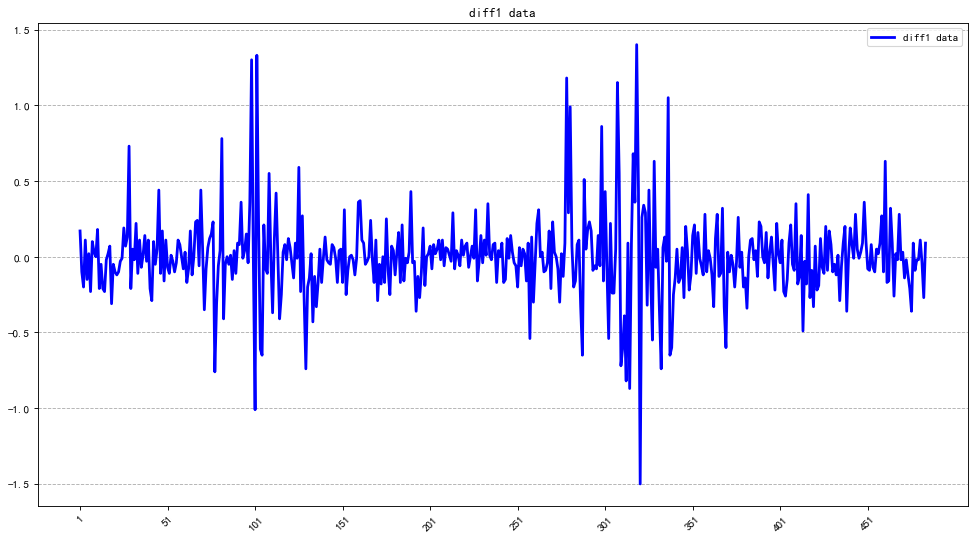

In [12]:
#若数据检验不平稳，则可以通过差分的方式使数据趋于平稳，如果数据已平稳，则不需要作差分操作，这里需要自取
diff1 = ts_data.diff(1)#一阶查分

#显示一阶差分结果
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(diff1, label="diff1 data", color='b',lw=2.5)
plt.title("diff1 data")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(data),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/diff1.png')
plt.show()

In [13]:
#检验一阶差分是否已经平稳
adf1, pvalue1, critical_values1 = adf_val(diff1.dropna(), 'raw time series')
print('adf1',adf1)
print('pvalue1',pvalue1)
print('critical_values1',critical_values1)
#检验一阶差分的白噪声
aco1=acorr_val(diff1.dropna())
print('aco1',aco1)
#若一阶差分仍不平稳，可以进行二阶差分
#此案例中一阶差分已经平稳，所以在后面的寻参中d=1

[('adf', -4.949073083926286), ('pvalue', 2.7963374070020164e-05), ('usedlag', 17), ('nobs', 466), ('critical_values', {'1%': -3.4444609168389615, '5%': -2.8677622536920317, '10%': -2.5700842229549266}), ('icbest', 128.75680108958318)]
adf1 -4.949073083926286
pvalue1 2.7963374070020164e-05
critical_values1 {'1%': -3.4444609168389615, '5%': -2.8677622536920317, '10%': -2.5700842229549266}
aco1 (array([0.00309651]), array([0.95562358]))


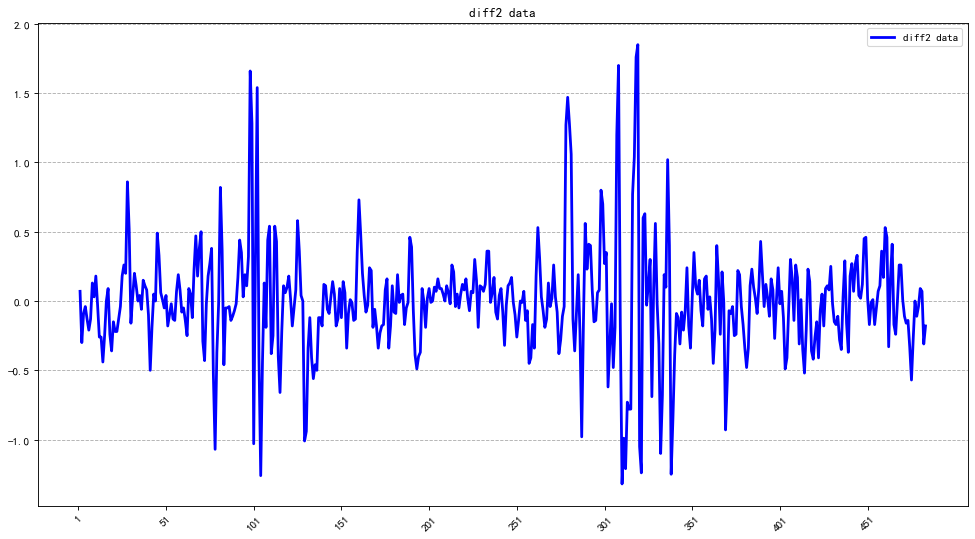

In [14]:
#在一阶差分的基础上进行二阶差分,若一阶差分不平稳可以作二阶差分，这里按需自取
diff2 = ts_data.diff(2)

#显示二阶差分的结果
fig = plt.figure(figsize=(15, 8), dpi=80)
plt.plot(diff2, label="diff2 data", color='b',lw=2.5)
plt.title("diff2 data")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(data),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/diff2.png')
plt.show()

(<AxesSubplot:title={'center':'origin  data'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

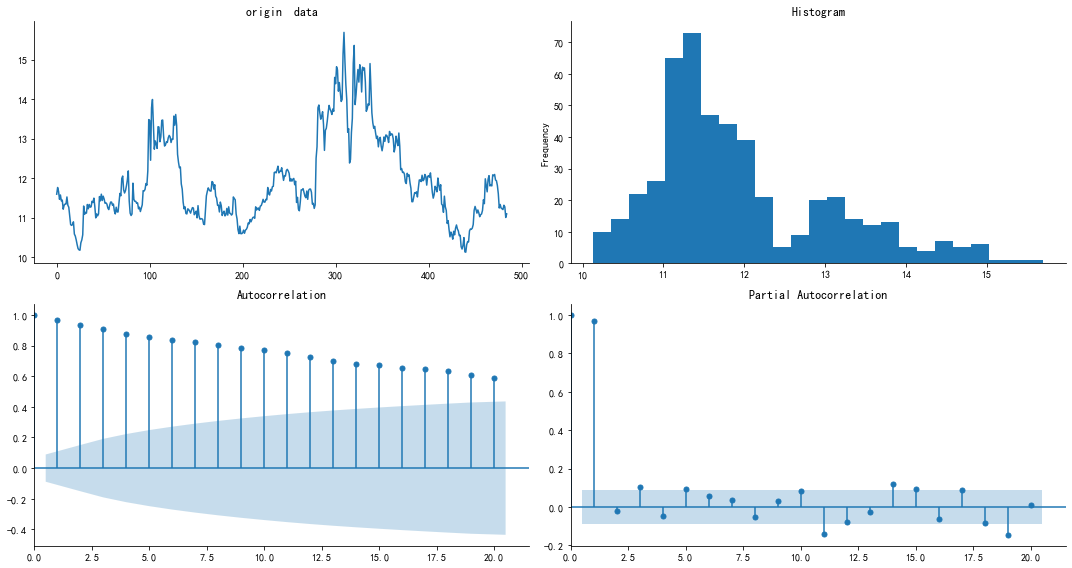

In [15]:
##显示原数据（未差分）的自相关ACF和偏自相关PACF
tsplot(ts_data, lags=20)

In [16]:
#下面这段用于寻找arima参数，若不会用可不用
#确定ARIMA的p、q、d参数，
#一种方式可以根据上述的ACF图和PACF图来确定，但通常由于主观性，不好确定；
#另一种方式可以用个AIC或者BIC指标进行选取参数，这里用AIC进行确定，采用网格搜索进行寻参

# #AIC和BIC计算最好的pdq值
q_arima = range(0, 3)#定义q值的范围
d_arima = 1 #d值为差分项，若原数据平稳不需要进行差分则d=0,否则d为原始数据差分稳定的阶数
p_arima = range(0, 3)#定义p值的范围
AIC_arima = [] #定义AIC列表存储AIC值
ARIMAX_model = []#定义模型参数列表存储参数值
#循环各组参数来试验哪组参数比较好
pdqs = [(x[0], d_arima, x[1]) for x in list(itertools.product(p_arima, q_arima))]

for pdq in pdqs:
    try:
        mod =ARIMA(data, order=pdq)
        results = mod.fit(disp=-1)
        print('ARIMA{} - AIC:{}'.format(pdq, results.aic))
        AIC_arima.append(results.aic)
        ARIMAX_model.append(pdq)
    except:
        continue

print('AIC_arima')
print(AIC_arima)
index=AIC_arima.index(min(AIC_arima))
order = ARIMAX_model[index] #获取最好的p，q,d参数值 （有些数据可能获取p,q,d参数会出现错误，这个需要修改一下参数范围或者百度一下解决）
print('order num',order)

ARIMA(0, 1, 0) - AIC:143.93862808154233
ARIMA(0, 1, 1) - AIC:145.93468093973252
ARIMA(0, 1, 2) - AIC:140.50322813203434
ARIMA(1, 1, 0) - AIC:145.9355539105934
ARIMA(1, 1, 1) - AIC:144.3399643495202
ARIMA(1, 1, 2) - AIC:142.00650504575606
ARIMA(2, 1, 0) - AIC:141.9830567402737
ARIMA(2, 1, 1) - AIC:142.2445626638314
ARIMA(2, 1, 2) - AIC:140.9740990498765
AIC_arima
[143.93862808154233, 145.93468093973252, 140.50322813203434, 145.9355539105934, 144.3399643495202, 142.00650504575606, 141.9830567402737, 142.2445626638314, 140.9740990498765]
order num (0, 1, 2)


In [17]:
#根据AIC寻参的结果定义ARIMA参数为（2,1,2）
order=(0,1,1)#有时候寻参出来的参数也不一定能用，可能需要调一下（出错情况下）

# # 构建训练数据
ndata=np.array(data).reshape(-1,1)#转换数据格式为array类型（方便取值操作）
#划分训练集和测试集
train_len=int(len(ndata)*0.8)#取95%数据作为训练集
train_ar = ndata[:train_len,:]#取数据[行或行区间(:),列或列区间(:)]
test_ar = ndata[train_len:,:]

history = [x for x in train_ar]
print(type(history))
pre = list()

#训练ARIMA模型
for t in range(len(test_ar)):
    model = ARIMA(history, order=order)
    model_fit = model.fit(disp=0)#模型训练
    output = model_fit.forecast()#模型预测
    yhat = output[0]
    pre.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

#数据类型转换
pre=np.array(pre)

<class 'list'>
predicted=11.660986, expected=11.530000
predicted=11.527189, expected=11.760000
predicted=11.764838, expected=11.960000
predicted=11.964970, expected=11.960000
predicted=11.960827, expected=11.920000
predicted=11.919980, expected=12.080000
predicted=12.084505, expected=11.940000
predicted=11.938044, expected=11.970000
predicted=11.971565, expected=12.100000
predicted=12.103786, expected=12.050000
predicted=12.050103, expected=11.830000
predicted=11.826232, expected=12.050000
predicted=12.055141, expected=12.070000
predicted=12.071451, expected=12.030000
predicted=12.030332, expected=12.140000
predicted=12.143311, expected=11.910000
predicted=11.906835, expected=11.650000
predicted=11.645218, expected=11.500000
predicted=11.496785, expected=11.590000
predicted=11.591852, expected=11.800000
predicted=11.804831, expected=11.750000
predicted=11.749260, expected=11.660000
predicted=11.658318, expected=12.010000
predicted=12.017836, expected=11.830000
predicted=11.827401, expe

In [18]:
# model = ARIMA(ndata, order=order)
# model_fit = model.fit(disp=0)
# pre=model_fit.predict(train_len,len(ndata), typ='levels')
# #数据类型转换
# pre=np.array(pre)

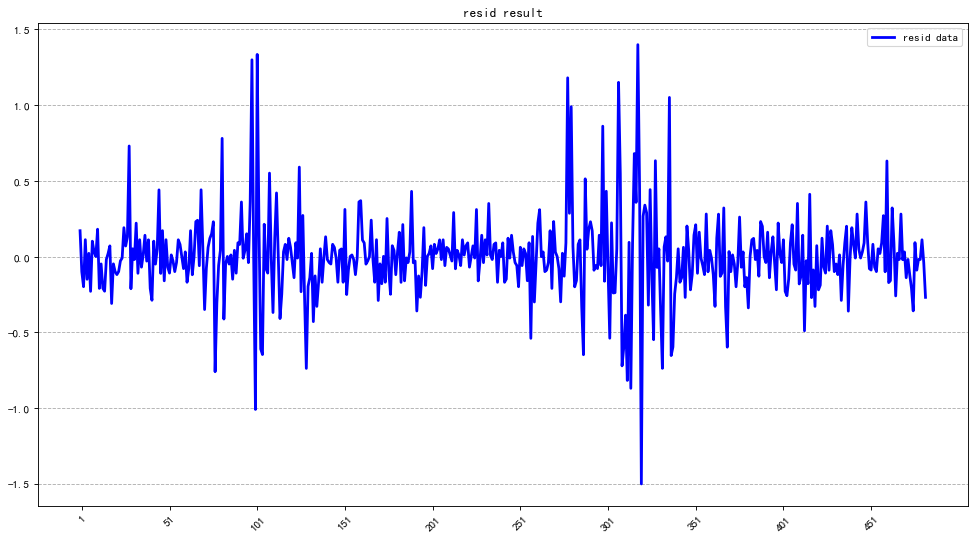

In [19]:
resid=model_fit.resid  #残差
#显示残差校验
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(resid, label="resid data", color='b',lw=2.5)
plt.title("resid result")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(data),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/resid_result.png')
plt.show()

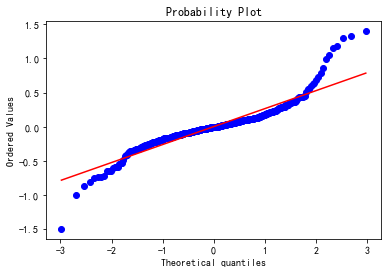

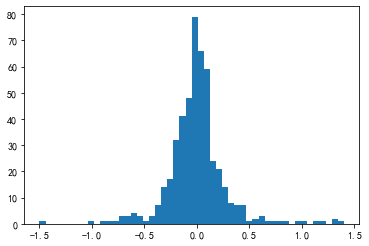

In [20]:
#
stats.normaltest(resid)#检验序列残差是否为正态分布
#qq图散点基本在直线上，同时直方图也呈现正态性
stats.probplot(resid, dist="norm", plot=plt)
plt.show()
plt.hist(resid,bins=50)
plt.show()

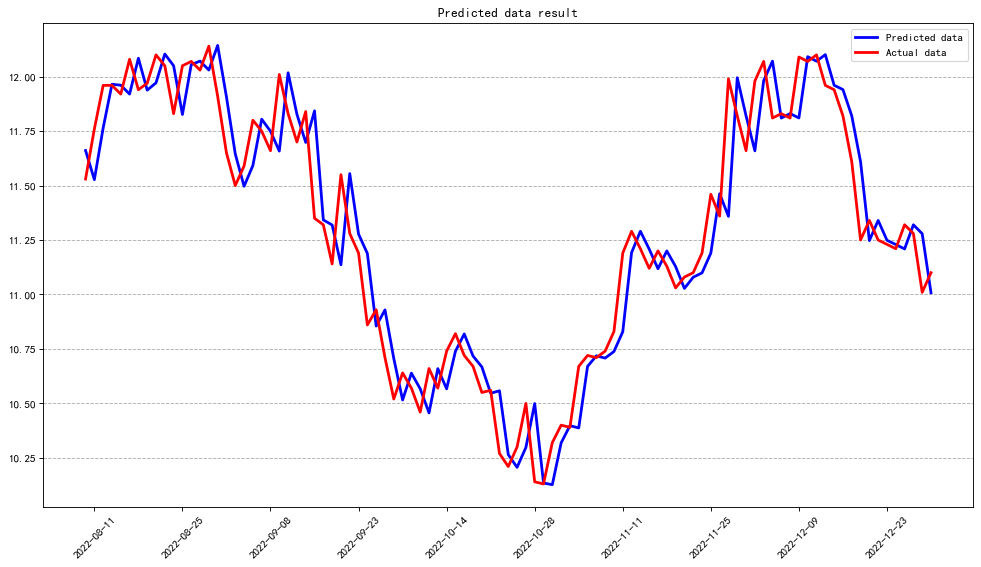

In [21]:
#显示预测结果
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(date[train_len:],pre, label="Predicted data", color='b',lw=2.5) #若不需要日期或者数据没有日期可改成plt.plot(pre, label="Predicted data", color='b',lw=2.5)
plt.plot(date[train_len:],test_ar, label="Actual data", color='r',lw=2.5)
plt.title("Predicted data result")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(pre),10),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/predict_result.png')
plt.show()


In [22]:
#保存Arima预测结果到本地
result=np.concatenate((pre.reshape(-1,1),test_ar),axis=1)
dg=pd.DataFrame(result,columns=['predict','true'])
dg.to_csv('result/result.csv')

In [23]:
#根据arima模型预测的值构建新的数据训练lstm
arima_result = pd.DataFrame(columns=['close'])#生成一个新的DataFrame空数据
arima_result['close'] = test_ar.ravel()#把ARIMA测试数据赋值给新的DataFrame空数据
arima_result['predicted'] = pre.ravel()#把ARIMA预测数据赋值给新的DataFrame空数据
arima_result['residuals'] = arima_result['close'] - arima_result['predicted']#获取这两数据的残缺

#以下是lstm部分
lstm_data=arima_result['residuals'].values#获取残缺项并做数据类型转换
#声明归一化变量
sc = MinMaxScaler(feature_range=(0, 1))
#反归一化
sc_data = sc.fit_transform(lstm_data.reshape(-1,1))


In [24]:
seq_len = 2  #时间步长 t-5,t-4,t-3,t-2,t-1 --->t
#转换成LSTM所需格式，（样本数，步长，特征数）
X_train = np.array([sc_data[i : i + seq_len, :] for i in range(sc_data.shape[0] - seq_len)])
y_train = np.array([sc_data[i + seq_len, :] for i in range(sc_data.shape[0]- seq_len)])

print(X_train.shape,y_train.shape)

(95, 2, 1) (95, 1)


In [25]:
#lstm网络,keras
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))#lstm层，神经元数为128
# model.add(LSTM(units=128,activation='tanh',return_sequences=False))#lstm层，神经元数为128
model.add(Dropout(0.2))#dropout层
model.add(Dense(1))#全连接层
model.compile(loss='mean_squared_error', optimizer='adam')
#训练
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)


Epoch 1/100
 - 1s - loss: 0.2174
Epoch 2/100
 - 0s - loss: 0.1945
Epoch 3/100
 - 0s - loss: 0.1717
Epoch 4/100
 - 0s - loss: 0.1519
Epoch 5/100
 - 0s - loss: 0.1346
Epoch 6/100
 - 0s - loss: 0.1145
Epoch 7/100
 - 0s - loss: 0.0992
Epoch 8/100
 - 0s - loss: 0.0841
Epoch 9/100
 - 0s - loss: 0.0722
Epoch 10/100
 - 0s - loss: 0.0598
Epoch 11/100
 - 0s - loss: 0.0477
Epoch 12/100
 - 0s - loss: 0.0429
Epoch 13/100
 - 0s - loss: 0.0364
Epoch 14/100
 - 0s - loss: 0.0336
Epoch 15/100
 - 0s - loss: 0.0317
Epoch 16/100
 - 0s - loss: 0.0324
Epoch 17/100
 - 0s - loss: 0.0308
Epoch 18/100
 - 0s - loss: 0.0301
Epoch 19/100
 - 0s - loss: 0.0326
Epoch 20/100
 - 0s - loss: 0.0326
Epoch 21/100
 - 0s - loss: 0.0307
Epoch 22/100
 - 0s - loss: 0.0302
Epoch 23/100
 - 0s - loss: 0.0324
Epoch 24/100
 - 0s - loss: 0.0306
Epoch 25/100
 - 0s - loss: 0.0314
Epoch 26/100
 - 0s - loss: 0.0332
Epoch 27/100
 - 0s - loss: 0.0290
Epoch 28/100
 - 0s - loss: 0.0330
Epoch 29/100
 - 0s - loss: 0.0315
Epoch 30/100
 - 0s - lo

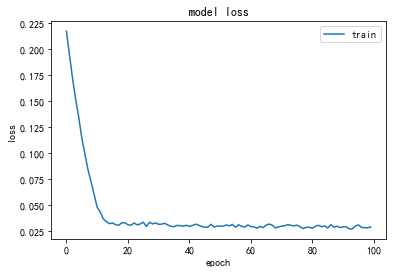

In [26]:
# 显示训练的loss值情况
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [27]:
# 预测训练集数据，预测数据为残缺项数据
lstm_pred = model.predict(X_train)
#对lstm_pred进行反归一化
lstm_pred = sc.inverse_transform(lstm_pred)#反归一化数据为为残缺项数据的预测数据
#对y_train进行反归一化
ytrue = sc.inverse_transform(y_train.reshape(-1,1))#反归一化数据为残缺项数据的真实值


In [28]:
#dtest为最终得到整个arima-lstm模型的预测结果，ytrue为真实值
arima_resid=arima_result['predicted'][-len(lstm_pred):].values.astype(float).reshape(-1,1)
dtest=arima_resid+lstm_pred
ytrue=arima_result['close'][-len(ytrue):].values.reshape(-1,1)+ytrue
#保存Arima-LSTM预测结果到本地
new_result=np.concatenate((dtest,ytrue),axis=1)
dg=pd.DataFrame(new_result,columns=['predict','true'])
dg.to_csv('result/arima_lstm_result.csv')

In [29]:
#计算评价指标
mse = mean_squared_error(ytrue, dtest)
mae = mean_absolute_error(ytrue, dtest)
rmse = np.sqrt(mse)
r2 = r2_score(ytrue,dtest)

print('mse: %.3f' % mse)
print('mae: %.3f' % mae)
print('rmse: %.3f' % rmse)
print('r2: %.3f' % r2)

mse: 0.136
mae: 0.286
rmse: 0.368
r2: 0.665


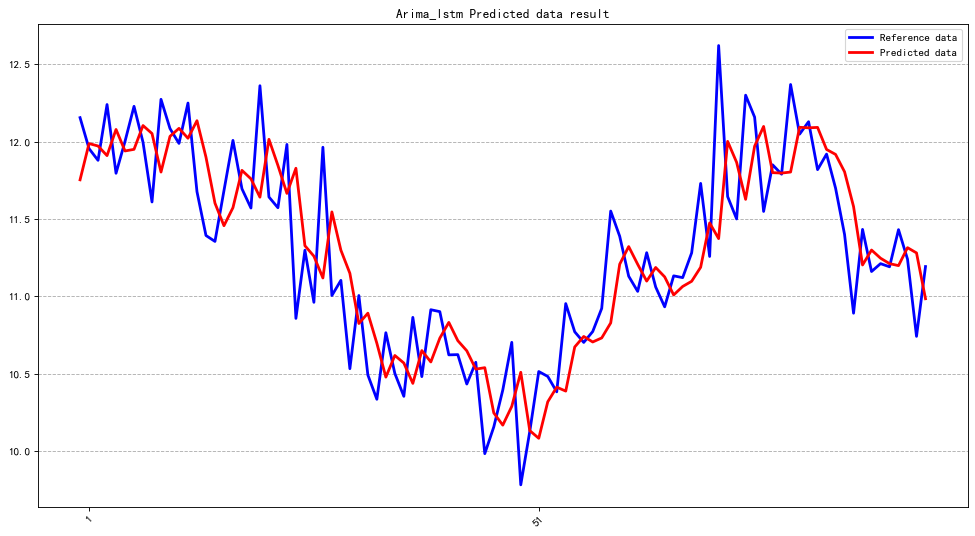

In [30]:
#显示ARIMA-LSTM预测结果
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(ytrue, label="Reference data", color='b',lw=2.5) #若不需要日期或者数据没有日期可改成plt.plot(pre, label="Predicted data", color='b',lw=2.5)
plt.plot(dtest, label="Predicted data", color='r',lw=2.5)
plt.title("Arima_lstm Predicted data result")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(pre),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/arima_lstm_predict_result1.png')
plt.show()

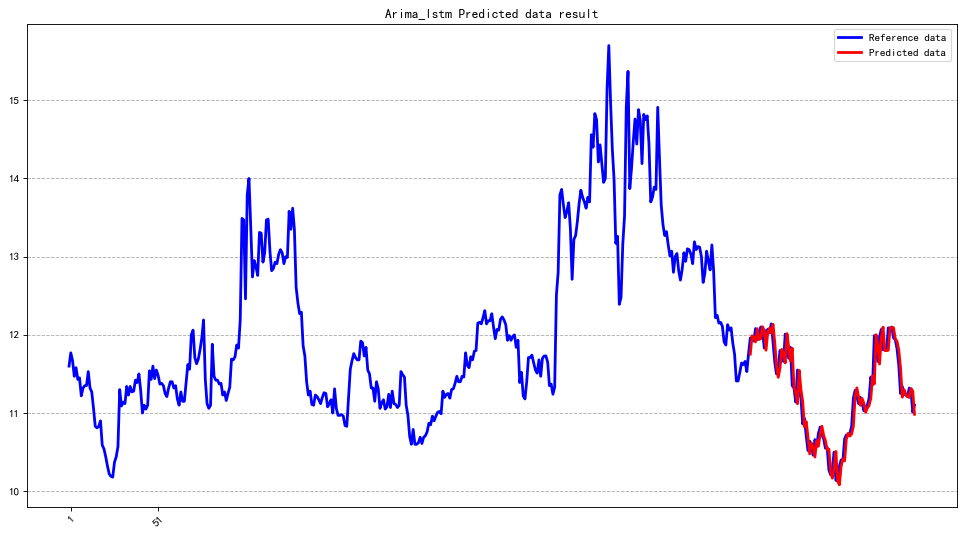

In [31]:
##显示前段数据段加上ARIMA-LSTM预测结果
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(ndata, label="Reference data", color='b',lw=2.5) #若不需要日期或者数据没有日期可改成plt.plot(pre, label="Predicted data", color='b',lw=2.5)
plt.plot(range(train_len+seq_len,len(ndata)),dtest, label="Predicted data", color='r',lw=2.5)
plt.title("Arima_lstm Predicted data result")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(pre),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/arima_lstm_predict_result2.png')
plt.show()

In [32]:
# # ### 1）CNN
# # ### 2）CNN-LSTM(复合算法)
# # ### 3）LSTM
# # ### 4）TCN
# # ### 5）GRU
# # ### 6）ARIMA
# # ### 7）ARIMA-LSTM(复合算法)
# # ### 8）TCN-LSTM(复合算法)
# # ### 9）TCN-Attention(复合算法)
# # ### 10）LSTM-Attention(复合算法)
# # ### 11）TCN-GRU(复合算法)
# # ### 12）informer(热门新型算法)
# # ### 13）transformer(热门新型算法)
# # ### 14）cnn-lstm-Attention(复合算法)
# # ### 15）VMD-LSTM/EMD-LSTM(预处理算法)